In [1]:
# Load packages
import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400 #high res figures
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import xgboost as xgb
import shap
import pickle

In [2]:
with open('../../Data/xgb_model_w_data.pkl', 'rb') as f:
    features_response, X_train_all, y_train_all, X_test_all,\
    y_test_all, xgb_model_4 = pickle.load(f)

# Model Predictions and Performance on Test Set

In [3]:
test_set_pred_proba = xgb_model_4.predict_proba(X_test_all)[:,1]

In [4]:
from sklearn.metrics import roc_auc_score
test_auc = roc_auc_score(y_test_all, test_set_pred_proba)
test_auc

0.7735528979671706

In [5]:
test_set_pred_proba.shape

(5938,)

Text(0, 0.5, 'Number of samples')

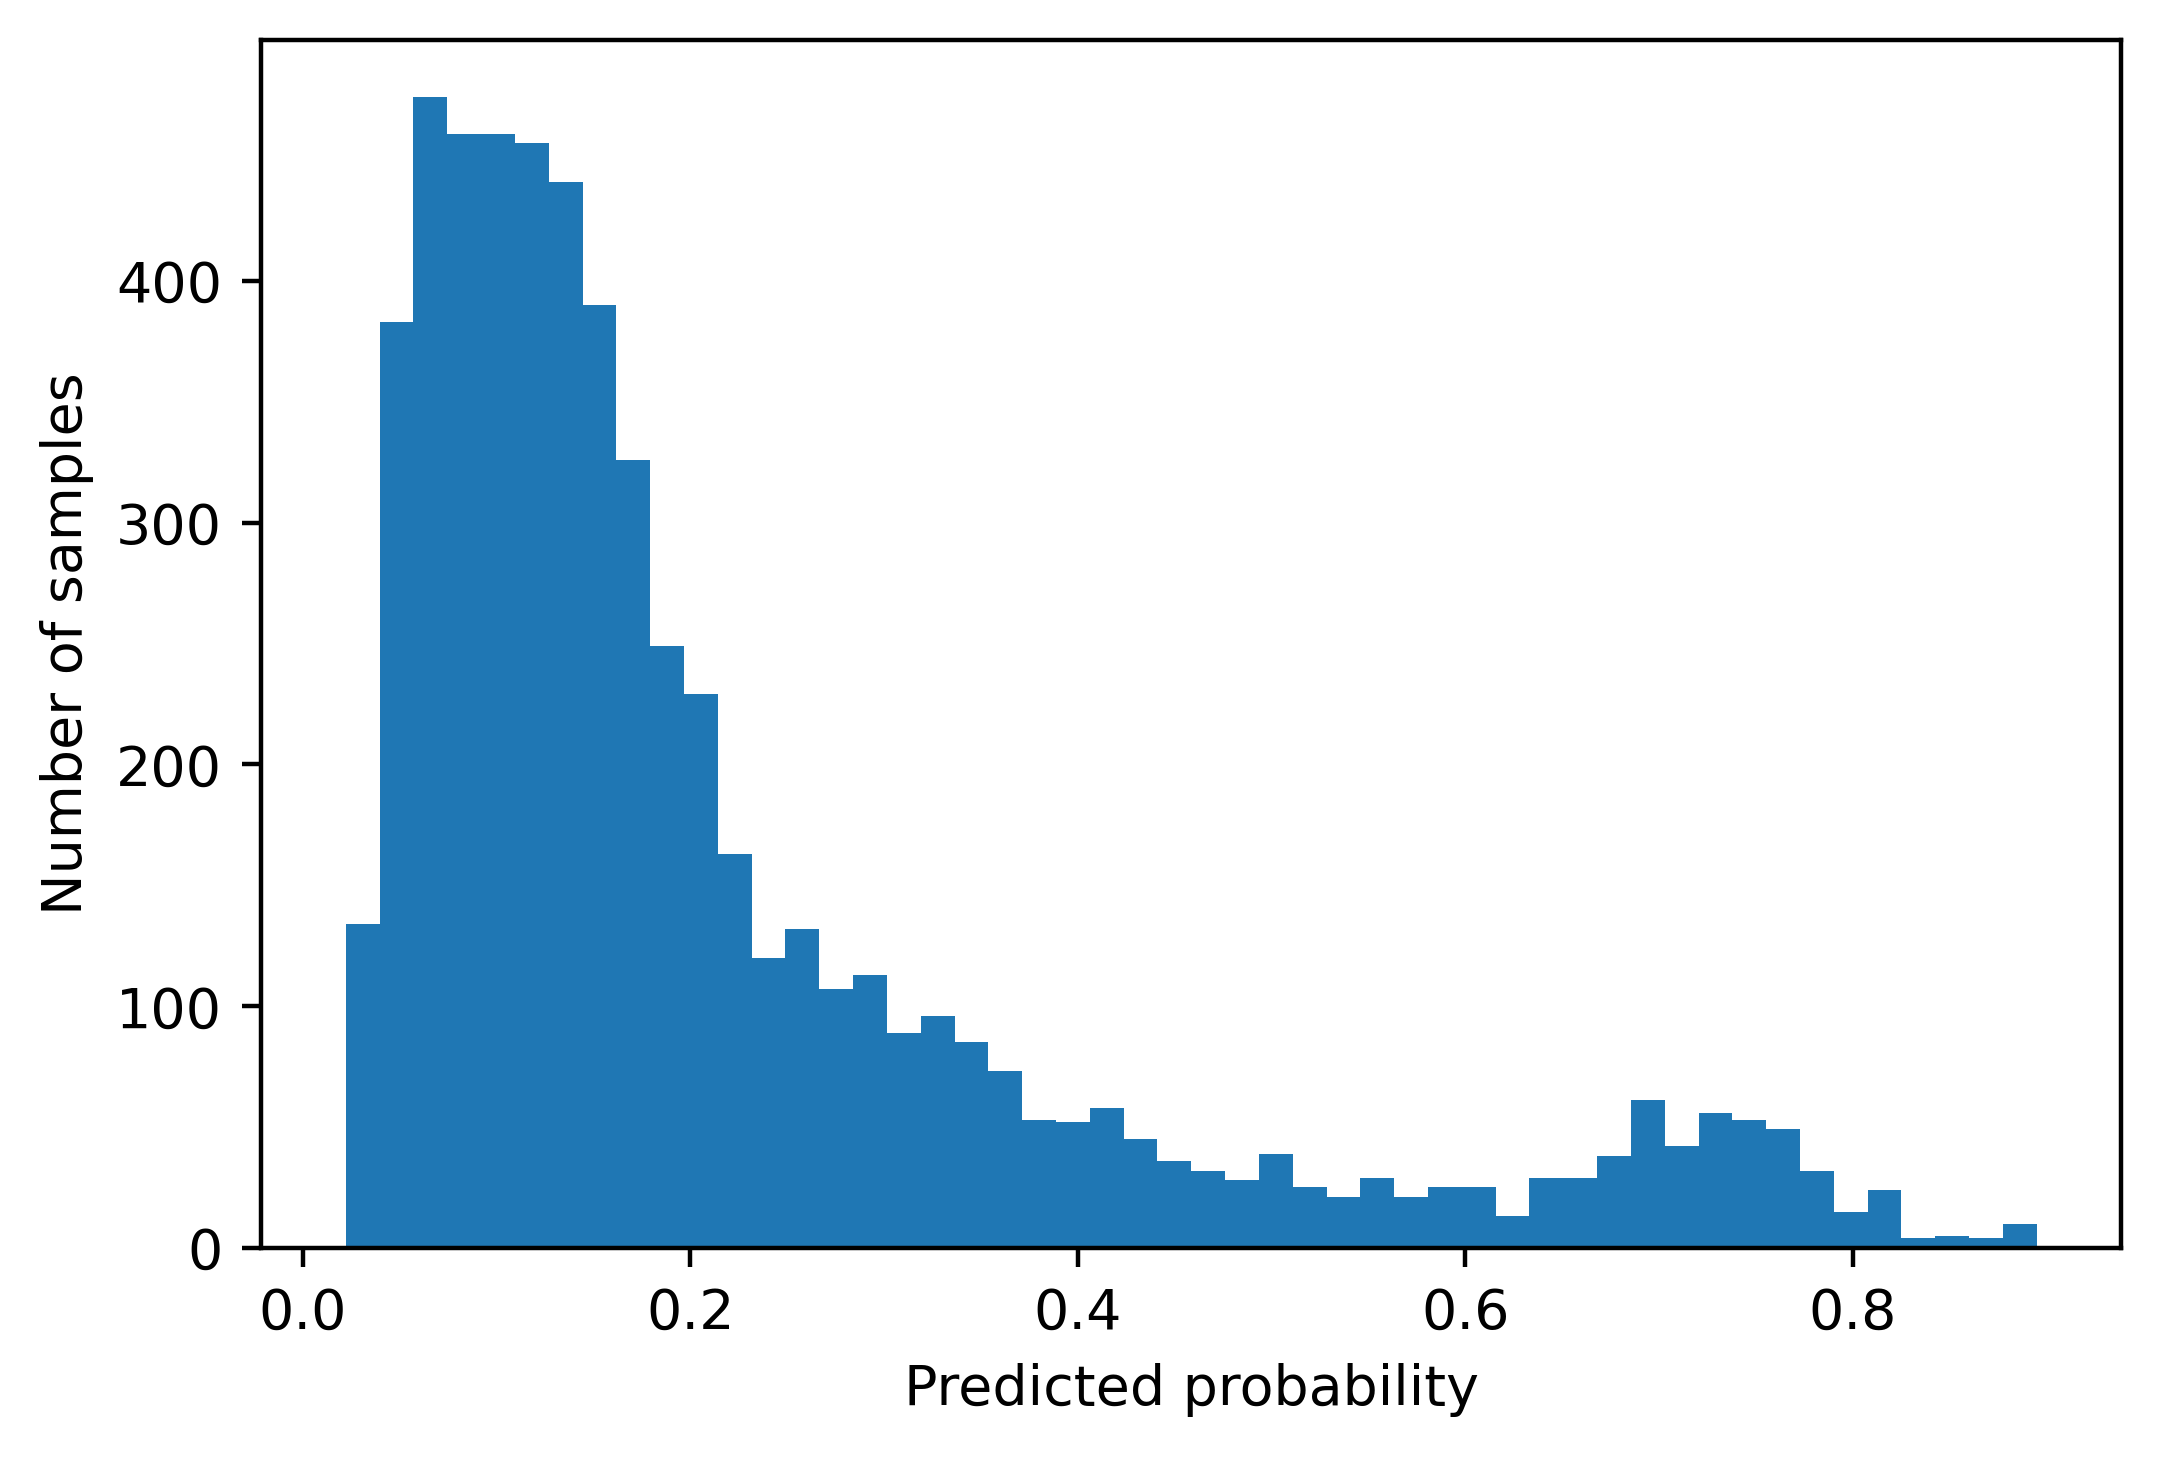

In [6]:
mpl.rcParams['figure.dpi'] = 400
plt.hist(test_set_pred_proba, bins=50)
plt.xlabel('Predicted probability')
plt.ylabel('Number of samples')

In [7]:
deciles, decile_bin_edges = pd.qcut(x=test_set_pred_proba,
                                    q=10,
                                    retbins=True)
# pandas.qcut(x, q, labels=None, retbins=False, precision=3, duplicates='raise')

In [8]:
decile_bin_edges

array([0.02213463, 0.06000734, 0.08155108, 0.10424594, 0.12708404,
       0.15019046, 0.18111563, 0.23032923, 0.32210371, 0.52585585,
       0.89491451])

In [9]:
test_set_df = pd.DataFrame({'Predicted probability':test_set_pred_proba,
                            'Prediction decile':deciles,
                            'Outcome':y_test_all})
test_set_df.head()

,Predicted probability,Prediction decile,Outcome
0,0.544556,"(0.526, 0.895]",0
1,0.621311,"(0.526, 0.895]",0
2,0.049883,"(0.0211, 0.06]",0
3,0.890924,"(0.526, 0.895]",1
4,0.272326,"(0.23, 0.322]",0


In [10]:
test_set_gr = test_set_df.groupby('Prediction decile')
gr_df = test_set_gr.agg({'Outcome':['count', 'mean']})

In [11]:
gr_df

Outcome          
                    count      mean
Prediction decile                  
(0.0211, 0.06]        594  0.045455
(0.06, 0.0816]        594  0.070707
(0.0816, 0.104]       594  0.099327
(0.104, 0.127]        593  0.112985
(0.127, 0.15]         594  0.116162
(0.15, 0.181]         594  0.171717
(0.181, 0.23]         593  0.195616
(0.23, 0.322]         594  0.282828
(0.322, 0.526]        594  0.392256
(0.526, 0.895]        594  0.676768

In [12]:
gr_df.columns

MultiIndex([('Outcome', 'count'),
            ('Outcome',  'mean')],
           )

In [13]:
gr_df[('Outcome', 'count')]

Prediction decile
(0.0211, 0.06]     594
(0.06, 0.0816]     594
(0.0816, 0.104]    594
(0.104, 0.127]     593
(0.127, 0.15]      594
(0.15, 0.181]      594
(0.181, 0.23]      593
(0.23, 0.322]      594
(0.322, 0.526]     594
(0.526, 0.895]     594
Name: (Outcome, count), dtype: int64

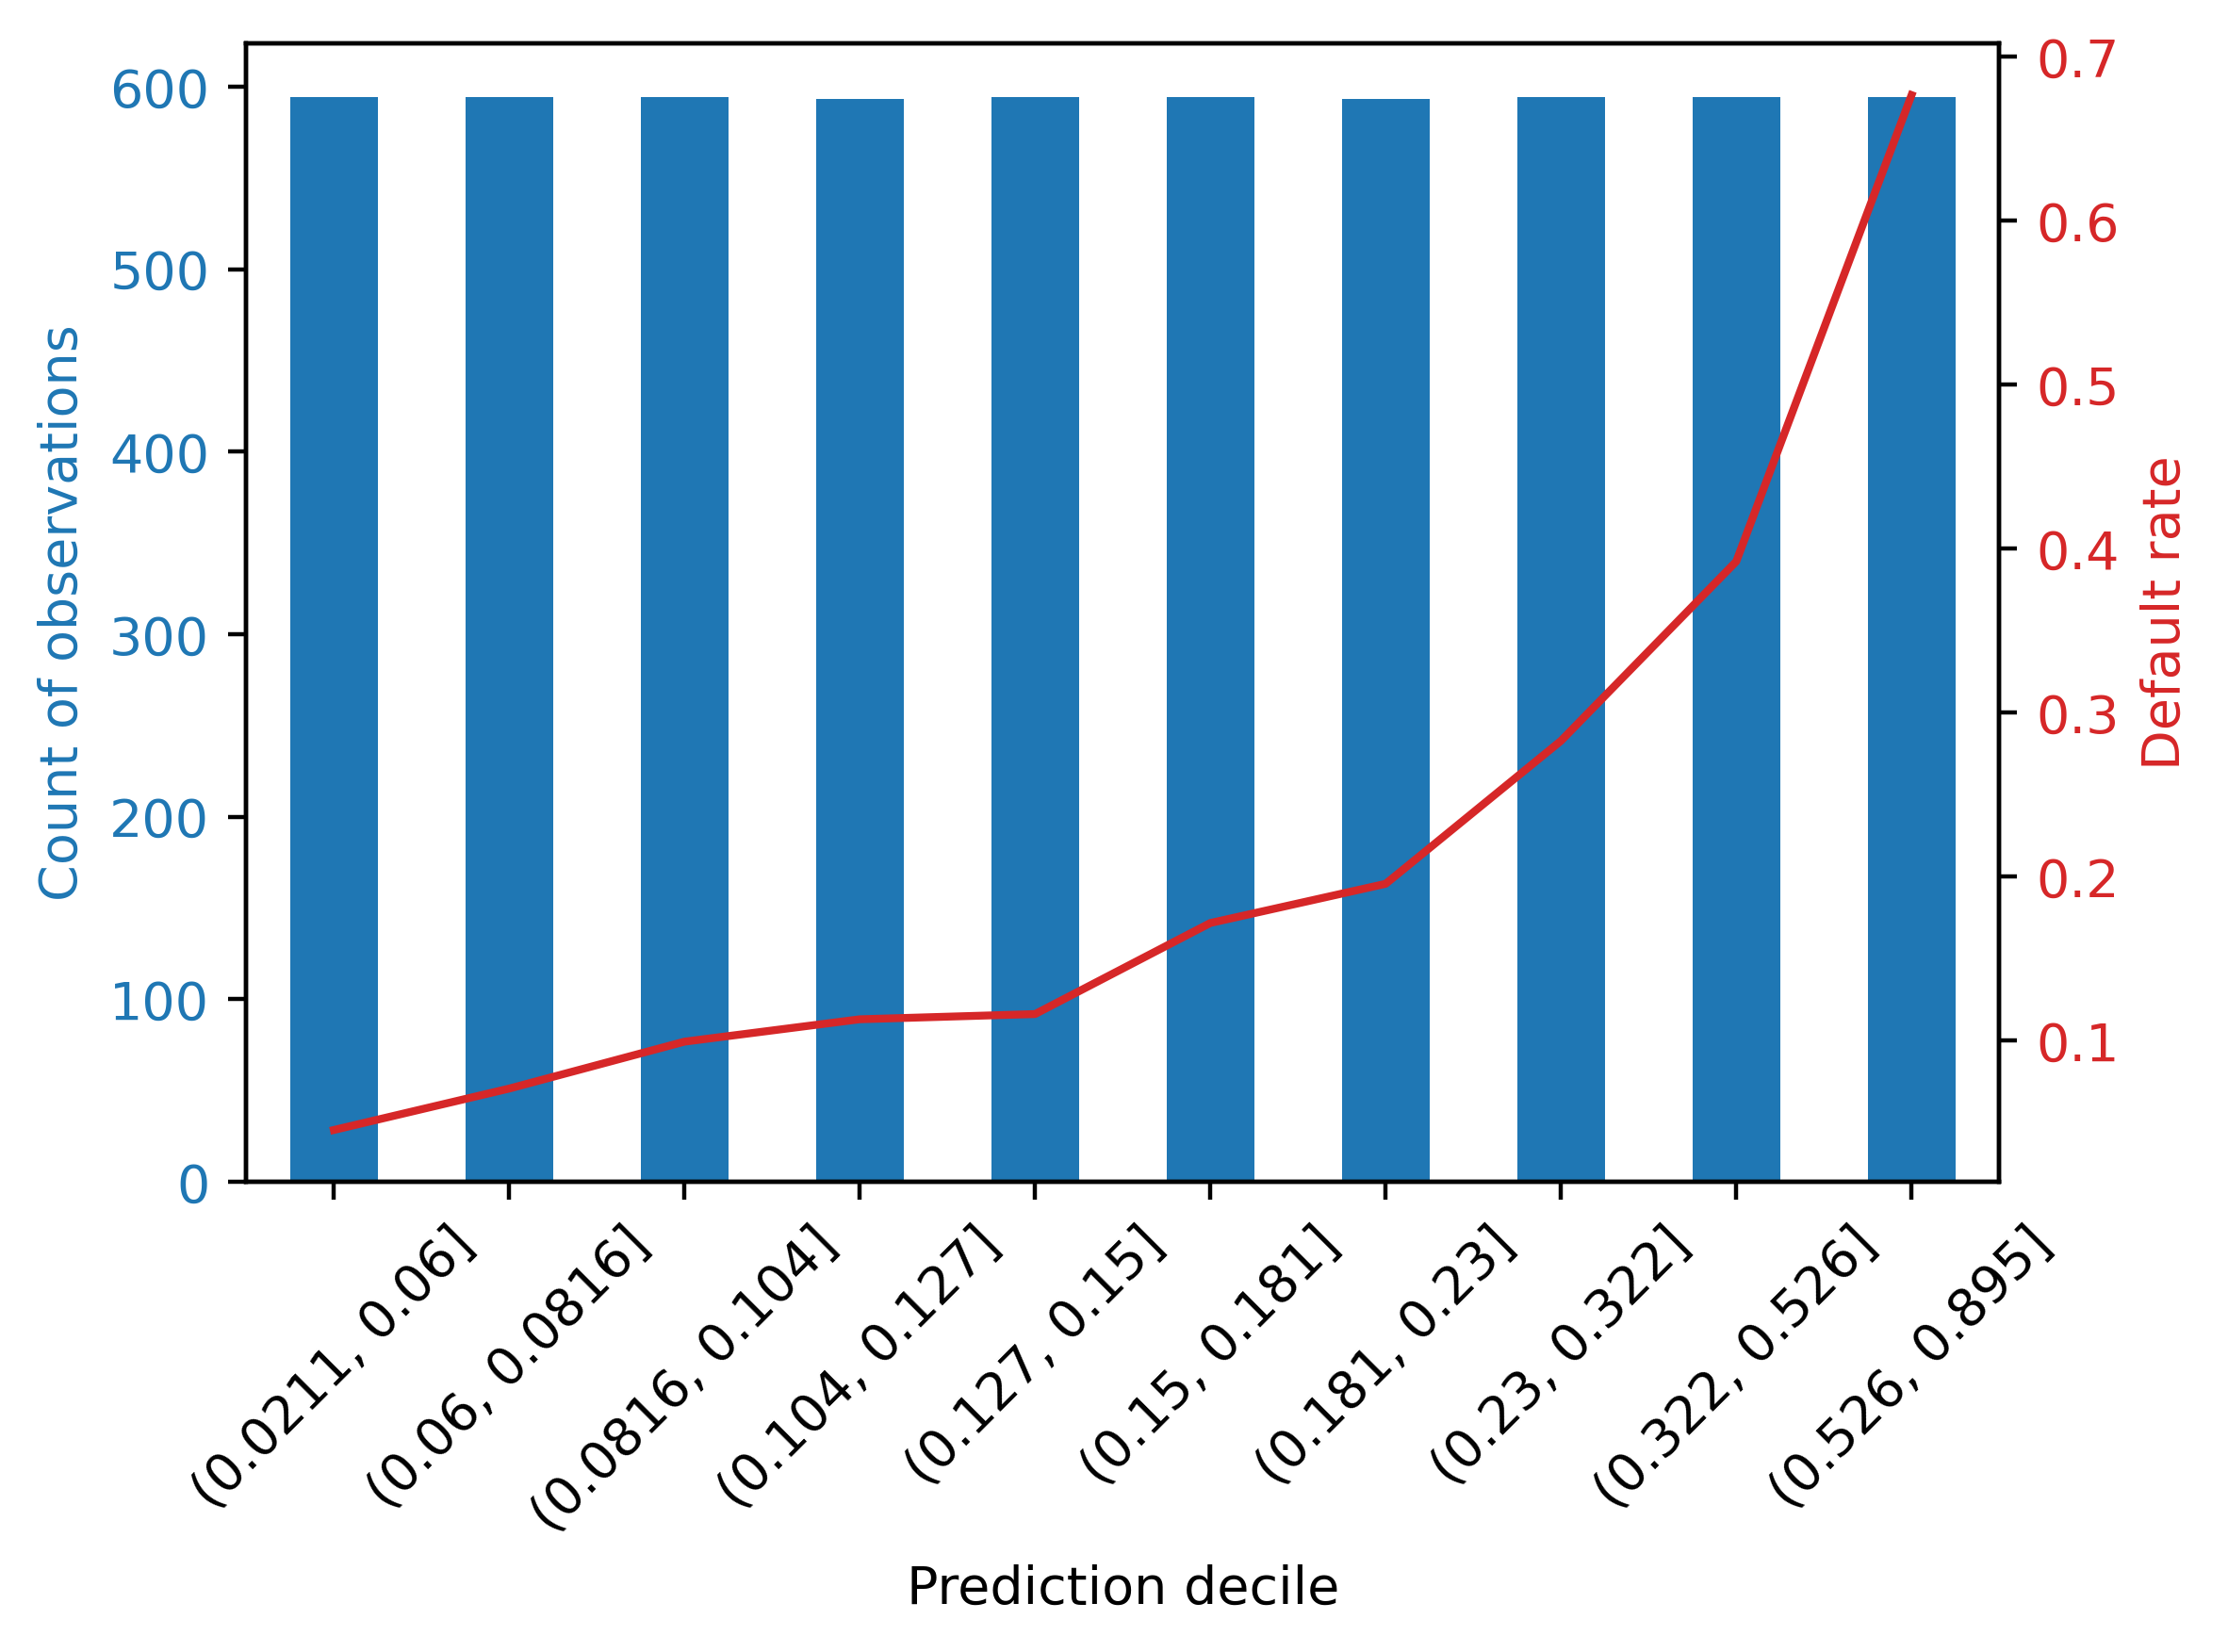

In [14]:
ax_1 = plt.axes()
color_1 = 'tab:blue'
gr_df[('Outcome', 'count')].plot.bar(ax=ax_1, color=color_1)
ax_1.set_ylabel('Count of observations', color=color_1)
ax_1.tick_params(axis='y', labelcolor=color_1)
ax_1.tick_params(axis='x', labelrotation = 45)

ax_2 = ax_1.twinx()
color_2 = 'tab:red'
gr_df[('Outcome', 'mean')].plot(ax=ax_2, color=color_2)
ax_2.set_ylabel('Default rate', color=color_2)
ax_2.tick_params(axis='y', labelcolor=color_2)

# Exercise 7.01: Equal Interval Chart

In [15]:
equal_intervals, equal_interval_bin_edges = \
    pd.cut(x=test_set_pred_proba,
           bins=5,
           retbins=True)
# pandas.qcut(x, q, labels=None, retbins=False, precision=3, duplicates='raise')

In [16]:
equal_interval_bin_edges

array([0.02126185, 0.1966906 , 0.37124658, 0.54580256, 0.72035853,
       0.89491451])

In [17]:
equal_interval_bin_edges[1:] - equal_interval_bin_edges[:-1]

array([0.17542876, 0.17455598, 0.17455598, 0.17455598, 0.17455598])

In [18]:
print(test_set_pred_proba.min())
print(test_set_pred_proba.max())

0.022134628
0.8949145


In [19]:
test_set_bins_df = pd.DataFrame({'Predicted probability':test_set_pred_proba,
                                 'Prediction decile':equal_intervals,
                                 'Outcome':y_test_all})
test_set_bins_df.head()

,Predicted probability,Prediction decile,Outcome
0,0.544556,"(0.371, 0.546]",0
1,0.621311,"(0.546, 0.72]",0
2,0.049883,"(0.0213, 0.197]",0
3,0.890924,"(0.72, 0.895]",1
4,0.272326,"(0.197, 0.371]",0


In [20]:
test_set_equal_gr = test_set_bins_df.groupby('Prediction decile')
gr_eq_df = test_set_equal_gr.agg({'Outcome':['count', 'mean']})

In [21]:
gr_eq_df

Outcome          
                    count      mean
Prediction decile                  
(0.0213, 0.197]      3778  0.108788
(0.197, 0.371]       1207  0.257664
(0.371, 0.546]        389  0.465296
(0.546, 0.72]         312  0.608974
(0.72, 0.895]         252  0.761905

In [22]:
p = gr_eq_df[('Outcome', 'mean')].values
n = gr_eq_df[('Outcome', 'count')].values
std_err = np.sqrt(p * (1-p) / n)
std_err

array([0.00506582, 0.01258848, 0.02528987, 0.02762643, 0.02683029])

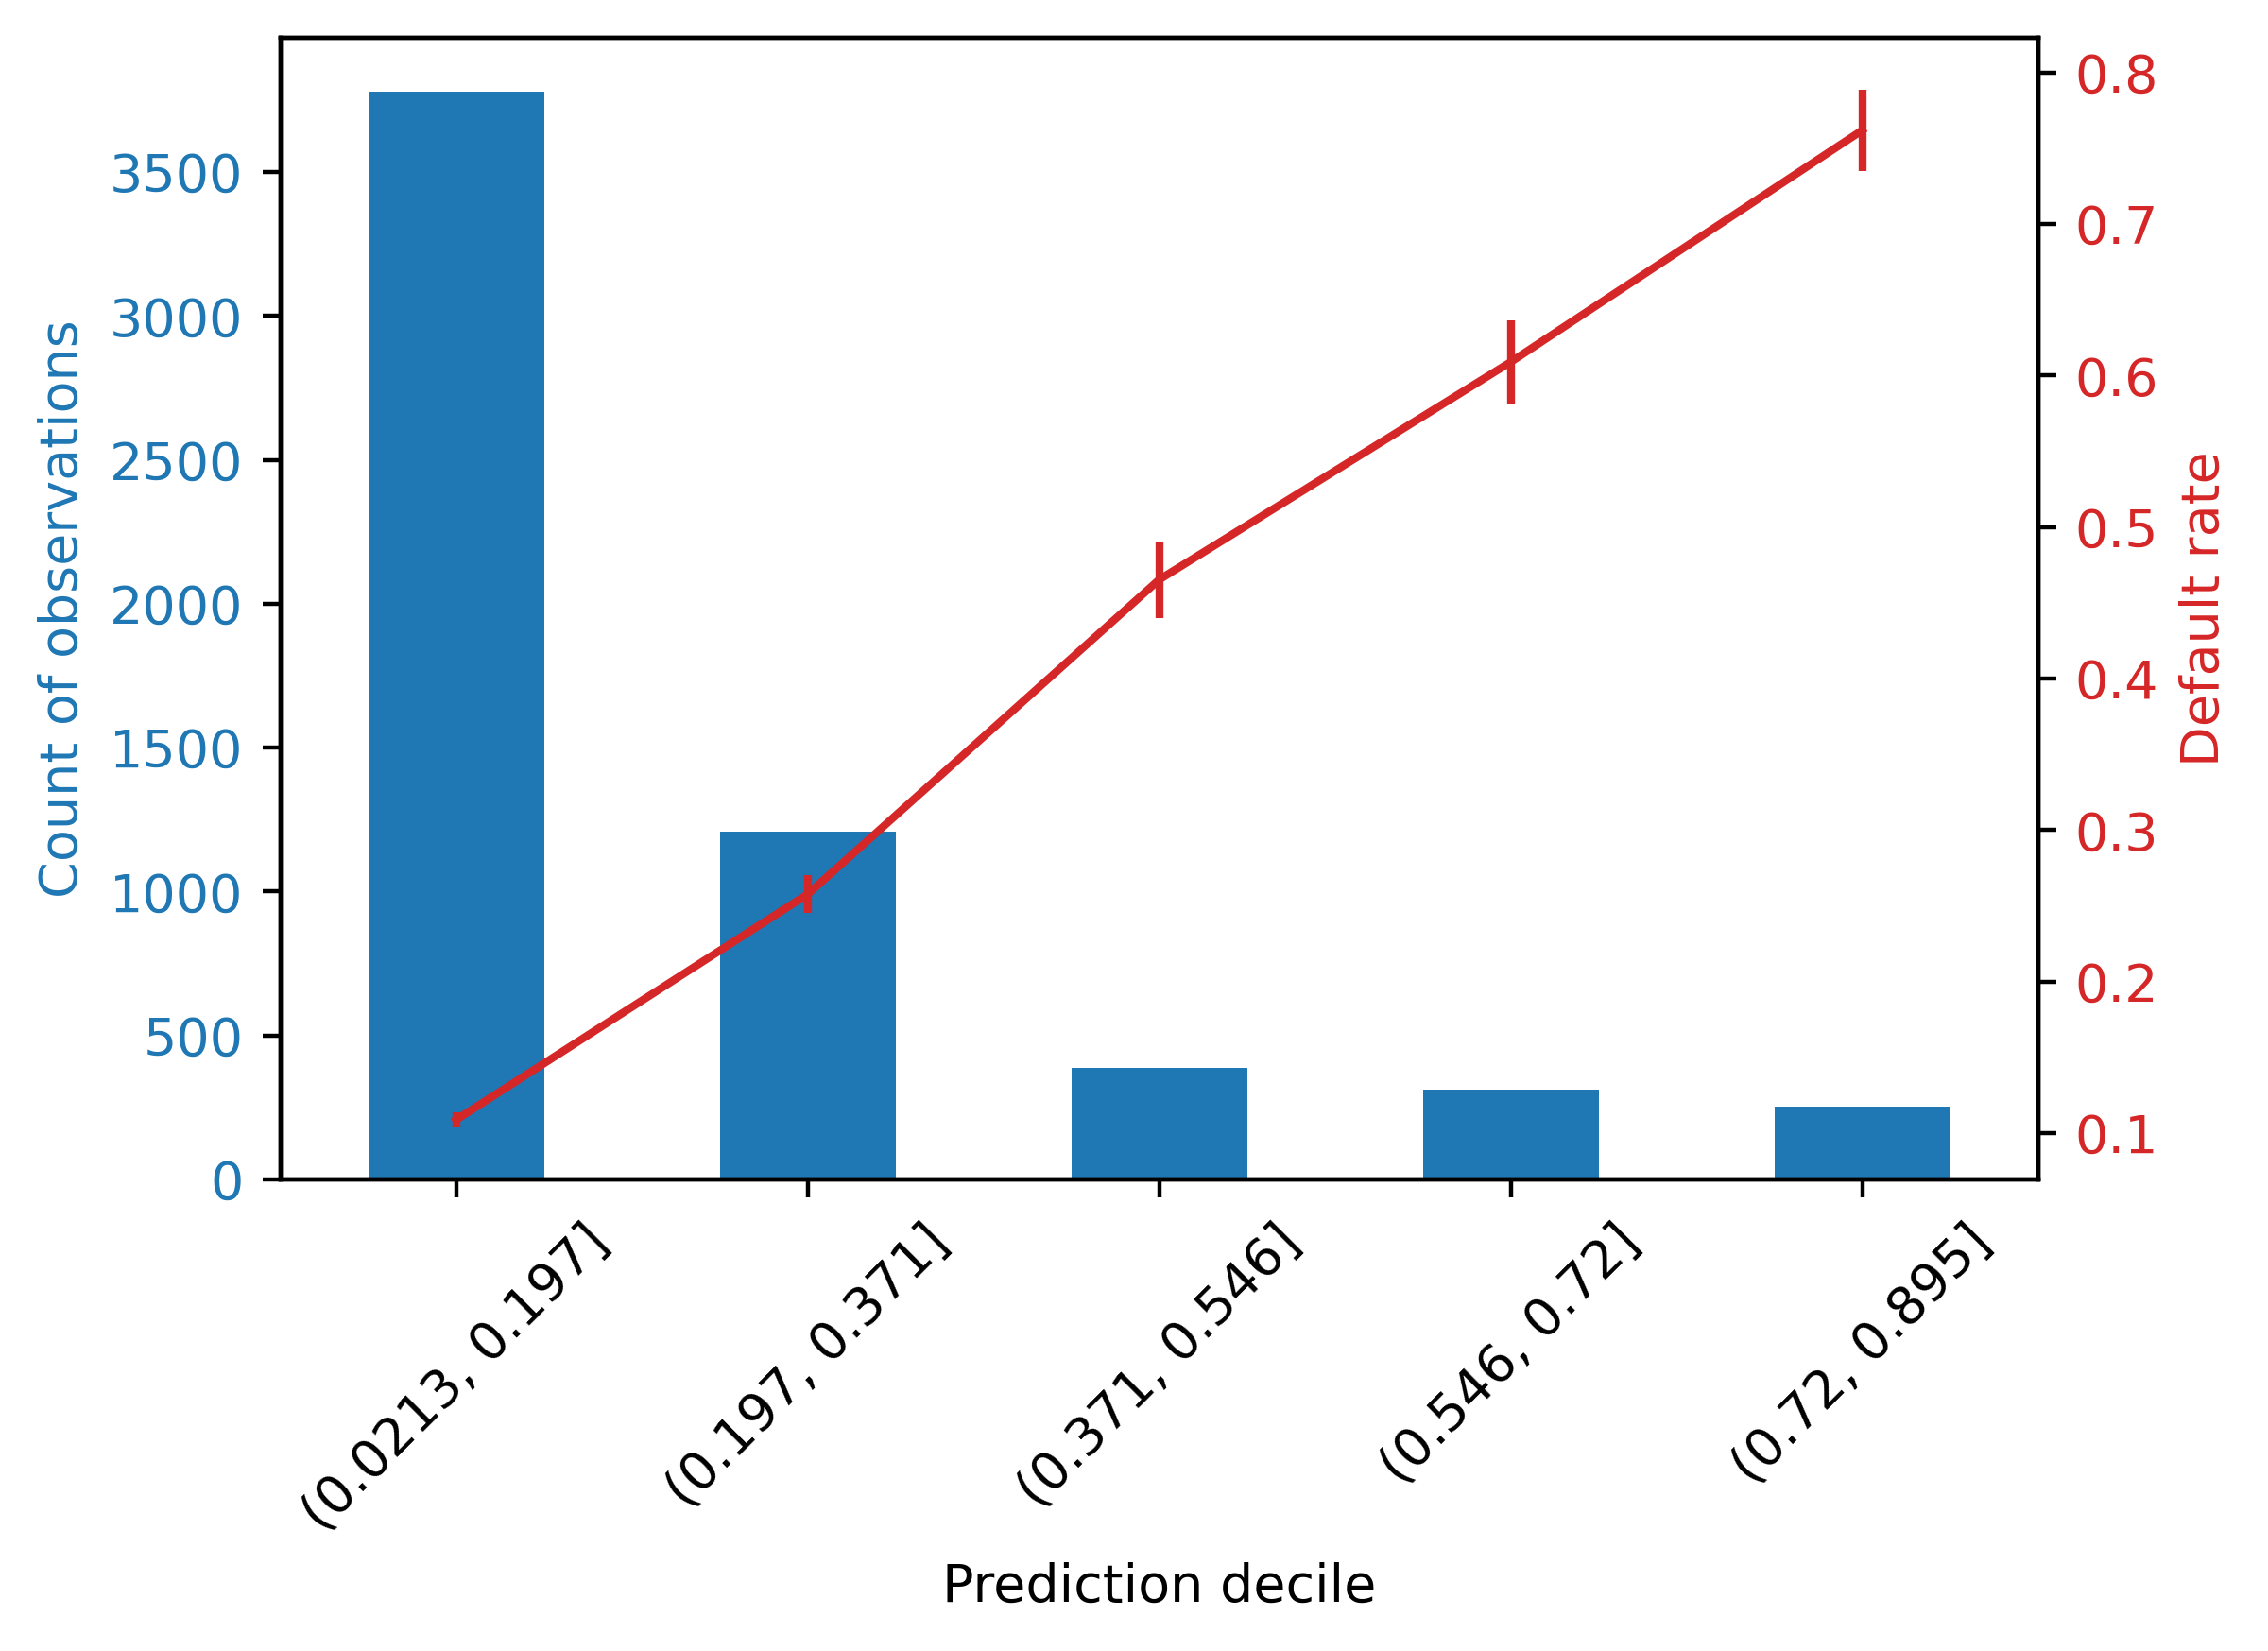

In [23]:
ax_1 = plt.axes()
color_1 = 'tab:blue'
gr_eq_df[('Outcome', 'count')].plot.bar(ax=ax_1, color=color_1)
ax_1.set_ylabel('Count of observations', color=color_1)
ax_1.tick_params(axis='y', labelcolor=color_1)
ax_1.tick_params(axis='x', labelrotation = 45)

ax_2 = ax_1.twinx()
color_2 = 'tab:red'
gr_eq_df[('Outcome', 'mean')].plot(ax=ax_2, color=color_2,
                                   yerr=std_err)
ax_2.set_ylabel('Default rate', color=color_2)
ax_2.tick_params(axis='y', labelcolor=color_2)